In [ ]:
#BA476: Using Binary Classification and Spotify Data to Predict Billboard Top 100 Placements
#Claire Choi, Rebecca Chang, Brett Rado, and Tristan Tew

import math
import pandas as pd
# from google.colab import drive
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeClassifierCV
from sklearn.model_selection import RandomizedSearchCV

# drive.mount('/content/drive')

In [ ]:
#df = pd.read_csv('C:/Users/trist/Manipulated_data.csv')
# df = pd.read_csv('/content/drive/MyDrive/BA476/data/Manipulated_data.csv')
df = pd.read_csv('C:/Users/17327/Google Drive/BA476/data/Manipulated_data.csv')

df = df.drop(["Unnamed: 0"], axis=1)
df.shape

(6344, 337)

# Data Pre-Processing

In [ ]:
#Break down all of the predictors into their respective categories

categorical_predictors = ["time_signature","key"
,"release_month","alb_type"]

poly_features = ["loudness","energy",'acousticness','instrumentalness']


all_predictors = df.loc[:, df.columns != 'target']
all_predictors

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,australiancountry,neo-classical,alternativecountry,symphonicblackmetal,progressivebluegrass,indiecoustica,soulfulhouse,position_on_album_ratio,duration_seconds,chorus_hit_percent
0,0.741,0.626,1,1.762331,0,11.286682,0.271442,0.000000,2.491327,0.7060,...,0,0,0,0,0,0,0,0.461538,5.239061,1.223156
1,0.447,0.247,5,2.751174,0,28.901734,0.955006,0.949852,2.358098,0.2500,...,0,0,0,0,0,0,0,0.818182,5.175472,1.194706
2,0.550,0.415,9,2.022474,0,19.230769,0.544012,0.000000,2.225624,0.2740,...,0,0,0,0,0,0,0,1.000000,5.325266,1.194706
3,0.502,0.648,0,1.901809,0,18.975332,0.172467,0.000000,1.589635,0.2910,...,0,0,0,0,0,0,0,0.222222,5.262913,1.124748
4,0.482,0.873,0,1.421903,1,11.723329,0.223070,0.000000,0.894040,0.7370,...,0,0,0,0,0,0,0,0.125000,5.367470,1.271150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6339,0.172,0.358,9,2.736314,1,29.239766,0.960457,0.991389,1.158362,0.0361,...,0,0,0,0,0,0,0,0.666667,5.016332,1.124748
6340,0.910,0.366,1,2.393705,1,10.626993,0.463539,0.000000,1.343235,0.7400,...,0,0,0,0,0,0,0,0.625000,5.023881,1.162283
6341,0.719,0.804,10,1.719368,1,28.169014,0.236333,0.041687,1.973281,0.6050,...,0,0,0,0,0,0,0,0.052632,5.428292,1.124748
6342,0.600,0.177,7,2.837323,1,17.825312,0.996320,0.965228,1.903809,0.5600,...,0,0,0,0,0,0,0,0.800000,5.363107,1.310506


In [ ]:
#Encode each of the features while maintaining understandable column names

#Iterate through each categorical predictor
for cat in categorical_predictors:

  #Add dummy variables to the predictor df for each categorical variable and assign appropriate labels
  all_predictors = pd.concat([all_predictors,pd.get_dummies(all_predictors[cat],prefix=cat)],axis=1)

  #Drop the original categorical column from the df
  all_predictors = all_predictors.drop(columns=cat)

#Instantiate polynomial features
poly= PolynomialFeatures(2, include_bias=False)

#Apply the polynomial fit to all columns and store them in their own df
df_poly = pd.DataFrame(poly.fit_transform(all_predictors[poly_features]))

#Assign labels to the polynomial features
df_poly.columns=poly.get_feature_names(all_predictors[poly_features].columns)

In [ ]:
#Drop the original variables for the poly features so there are no duplicates when df_poly and all_preds are merged
for pol in poly_features:

  #drop the poly columns
  df_poly = df_poly.drop(columns=pol)

#Create new df with all the labels
labelled_df = pd.concat([all_predictors,df_poly],axis=1)

In [ ]:
#Split into Train/Test Sets
X = labelled_df
y = df.loc[:,'target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

In [ ]:

#Standardize the Data Using StandardScaler
scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

#Turn the scaled numbers back into a dataframe with labels
X_scaled_train = pd.DataFrame(X_train, columns=list(X.columns.values))
X_scaled_test = pd.DataFrame(X_test, columns=list(X.columns.values))

# Baseline Model

In [ ]:
#Use SKlearn dummy as the baseline
dummy_strategies = ["stratified", "most_frequent","prior","uniform"]

best_baseline_accuracy = 0

best_strat = ''

for strat in dummy_strategies:
  #Instantiate model that will predict the majority class every time as opposed to random model
  dummy_model = DummyClassifier(strategy=strat, random_state=17)

  #Fit Model
  dummy_model.fit(X_scaled_train,y_train)

  #Predict
  y_pred_baseline = dummy_model.predict(X_scaled_test)
  y_pred_baseline_train = dummy_model.predict(X_scaled_train)

  #Define Baseline Accuracy
  baseline_accuracy = metrics.accuracy_score(y_test,y_pred_baseline)
  print("Accuracy:",baseline_accuracy,"strategy:",strat)
  if baseline_accuracy > best_baseline_accuracy:
    best_baseline_accuracy = baseline_accuracy
    best_strat = strat
    best_baseline_yhat = y_pred_baseline
    best_baseline_model = dummy_model
    best_baseline_accuracy_train = metrics.accuracy_score(y_train,y_pred_baseline_train)

Accuracy: 0.5145784081954294 strategy: stratified
Accuracy: 0.4988179669030733 strategy: most_frequent
Accuracy: 0.4988179669030733 strategy: prior
Accuracy: 0.48148148148148145 strategy: uniform


In [ ]:
best_baseline_accuracy, best_strat

(0.5145784081954294, 'stratified')

<AxesSubplot:>

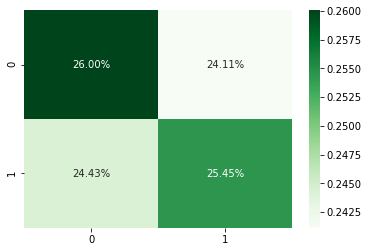

In [ ]:
matrix = metrics.confusion_matrix(y_test,best_baseline_yhat)
sns.heatmap(matrix/np.sum(matrix), annot=True, 
            fmt='.2%',cmap="Greens")

#Logistic Regression Model

In [ ]:
p_terms = np.logspace(-5, 5, 1000)
penalty = ["l2","none"]

parameter_grid = {
    'penalty': penalty,
    'C': p_terms
}

logistic_model = RandomizedSearchCV(LogisticRegression(max_iter=10000), parameter_grid, scoring='accuracy',random_state=17,return_train_score=True)

#Fit Model
logistic_model.fit(X_scaled_train, y_train)

#Predict
y_pred_logistic = logistic_model.predict(X_scaled_test)
y_pred_train_log = logistic_model.predict(X_scaled_train)

#Score Train and Test
logistic_accuracy = metrics.accuracy_score(y_test,y_pred_logistic)
logistic_accuracy_train = metrics.accuracy_score(y_train,y_pred_train_log)

In [ ]:
print("Test Logistic Accuracy:", logistic_accuracy)
print("Logistic Train Accuracy:", logistic_accuracy_train)
print('Best Parameters:', logistic_model.best_params_)

Test Logistic Accuracy: 0.933806146572104
Logistic Train Accuracy: 0.947192118226601
Best Parameters: {'penalty': 'l2', 'C': 119.42000281335325}


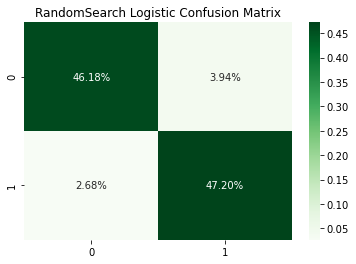

In [ ]:
matrix = metrics.confusion_matrix(y_test,y_pred_logistic)
sns.heatmap(matrix/np.sum(matrix), annot=True, 
            fmt='.2%',cmap="Greens")

plt.title('RandomSearch Logistic Confusion Matrix')
plt.show()

In [ ]:
#Store the logistic coefficients
coef = logistic_model.best_estimator_.coef_[0]

#Get the names of the columns from one of the X sets
names = X_scaled_train.columns.values

#Create a df with the columns and coefficients to display
df = pd.DataFrame({'column name':names,'coefficient':coef})

#create a new df with the absolute value of the coefficients
df2 = pd.DataFrame({'Abs Coef':abs(df['coefficient'])})

#Sort the coefficients by largest 25 absolute values; maintain sign to see if coef is positive or negative
top_25_logistic_coefficients=pd.concat([df,df2],axis=1).sort_values(by='Abs Coef',ascending=False)[0:25]

#display top 25 coefficients
top_25_logistic_coefficients

,column name,coefficient,Abs Coef
364,loudness^2,-3.331573,3.331573
1,energy,3.122966,3.122966
2,loudness,2.840969,2.840969
5,acousticness,2.623098,2.623098
368,energy^2,-1.951766,1.951766
77,hollywood,1.732425,1.732425
220,experimental,-1.693790,1.693790
11,sections,-1.558822,1.558822
108,chillwave,-1.499193,1.499193
331,chorus_hit_percent,1.468203,1.468203


#Ridge Classification Model

In [ ]:
#Also try ridgeclassifier in randomsearch across a logspace
lambdas = np.logspace(-5, 5, 1000)

parameter_grid = {
    'alpha': lambdas,
}

#Instantiate Ridge Classifier in GridSearch across our lambda range; note that cv=none lets us use LOOCV vs k-fold
ridge_model = RandomizedSearchCV(RidgeClassifier(),parameter_grid, scoring='accuracy',return_train_score=True,random_state=17)

#Fit the model
ridge_model.fit(X_scaled_train,y_train)


ridge_yhats = ridge_model.predict(X_scaled_test)
ridge_train_yhats = ridge_model.predict(X_scaled_train)

#Use ridge_model to get the accuracy of the cross-validated model
ridge_accuracy = metrics.accuracy_score(y_test,ridge_yhats)
ridge_accuracy_train = metrics.accuracy_score(y_train,ridge_train_yhats)

In [ ]:
print("Ridge Test Accuracy:",ridge_accuracy)
print("Ridge Train Accuracy:",ridge_accuracy_train)
print("Best Lambda:", ridge_model.best_params_)

Ridge Test Accuracy: 0.9227738376674547
Ridge Train Accuracy: 0.9400985221674877
Best Lambda: {'alpha': 336.9205705980267}


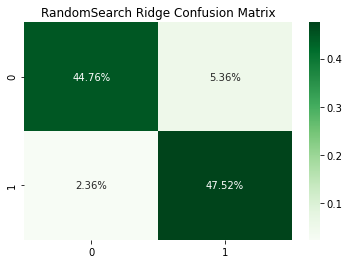

In [ ]:
matrix = metrics.confusion_matrix(y_test,ridge_yhats)
sns.heatmap(matrix/np.sum(matrix), annot=True, 
            fmt='.2%',cmap="Greens")


plt.title('RandomSearch Ridge Confusion Matrix')
plt.show()

In [ ]:
coef = ridge_model.best_estimator_.coef_[0]
names = X_scaled_train.columns.values
df = pd.DataFrame({'column name':names,'coefficient':coef})

df2 = pd.DataFrame({'Abs Coef':abs(df['coefficient'])})
top_25_ridge_coefficients=pd.concat([df,df2],axis=1).sort_values(by='Abs Coef',ascending=False)[0:25]
top_25_ridge_coefficients

,column name,coefficient,Abs Coef
17,pop,0.206814,0.206814
28,country,0.201891,0.201891
19,rap,0.156388,0.156388
45,metal,-0.132967,0.132967
6,instrumentalness,-0.115757,0.115757
150,punk,-0.104327,0.104327
133,crunk,-0.079974,0.079974
78,filmi,-0.073756,0.073756
361,alb_type_album,0.071608,0.071608
370,energy instrumentalness,-0.070340,0.070340


#Decision Trees

In [ ]:
test_depths = [x for x in range(1,1001)]
criteria = ['gini']
splitter = ['best','random']

parameter_grid = {
    'max_depth': test_depths,
    'criterion': criteria,
    'splitter': splitter
}

dt = RandomizedSearchCV(DecisionTreeClassifier(random_state=17), parameter_grid, scoring='accuracy', random_state=17,return_train_score=True)

#Fit
dt.fit(X_scaled_train, y_train)

#predict 
y_hat_tree = dt.predict(X_scaled_test)
y_hat_train_tree = dt.predict(X_scaled_train)

#Check
tree_acc = metrics.accuracy_score(y_test, y_hat_tree)
tree_train_acc = metrics.accuracy_score(y_train, y_hat_train_tree)

In [ ]:
print('Tree Test Accuracy:',tree_acc)
print('Tree Train Accuracy:',tree_train_acc)
print(dt.best_params_)

Tree Test Accuracy: 0.8896769109535066
Tree Train Accuracy: 0.9996059113300493
{'splitter': 'random', 'max_depth': 312, 'criterion': 'gini'}


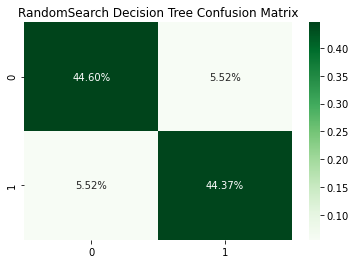

In [ ]:
matrix = metrics.confusion_matrix(y_test,y_hat_tree)
sns.heatmap(matrix/np.sum(matrix), annot=True, 
            fmt='.2%',cmap="Greens")


plt.title('RandomSearch Decision Tree Confusion Matrix')
plt.show()

In [ ]:
coef = dt.best_estimator_.feature_importances_
names = X_scaled_train.columns.values
df = pd.DataFrame({'Column name':names,'Coefficient':coef}).sort_values(by='Coefficient',ascending=False)
top_25_dt_features = df[0:25]
top_25_dt_features

,Column name,Coefficient
373,instrumentalness^2,0.349773
362,alb_type_compilation,0.056856
17,pop,0.053665
19,rap,0.043650
45,metal,0.035011
28,country,0.028070
150,punk,0.025385
145,worship,0.022838
15,genres_count,0.019125
78,filmi,0.017984


#KNN

In [ ]:
neighbors = [x for x in range(1,501)]
weights = ['uniform','distance']

param_grid = {
    'n_neighbors': neighbors,
    'weights': weights
}
knn_model = RandomizedSearchCV(KNeighborsClassifier(), param_grid, scoring='accuracy', random_state=17,return_train_score=True)

#Fit
knn_model.fit(X_scaled_train, y_train)

#predict 
y_hat_knn = knn_model.predict(X_scaled_test)
y_hat_train_knn = knn_model.predict(X_scaled_train)

#Check
knn_acc = metrics.accuracy_score(y_test, y_hat_knn)
knn_train_acc = metrics.accuracy_score(y_train, y_hat_train_knn)


In [ ]:
print(knn_acc)
print(knn_train_acc)
print(knn_model.best_params_)

0.8833727344365643
0.9996059113300493
{'weights': 'distance', 'n_neighbors': 16}


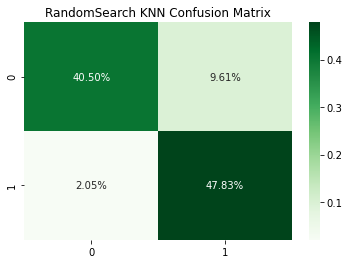

In [ ]:
matrix = metrics.confusion_matrix(y_test,y_hat_knn)
sns.heatmap(matrix/np.sum(matrix), annot=True, 
            fmt='.2%',cmap="Greens")

plt.title('RandomSearch KNN Confusion Matrix')
plt.show()

#Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
depths = [x for x in range(1,101)]
trees = [x for x in range(1,1001)]
features = [x for x in range(1,len(X_scaled_test.columns))]

param_grid = {
    'max_depth': depths,
    'max_features': features,
    'n_estimators': trees}

random_forest_model = RandomizedSearchCV(RandomForestClassifier(random_state=17), param_grid, scoring='accuracy',random_state=17,return_train_score=True)

#Fit
random_forest_model.fit(X_scaled_train, y_train)

#predict 
y_hat_rf = random_forest_model.predict(X_scaled_test)
y_hat_rf_train = random_forest_model.predict(X_scaled_train)

#Check
rf_acc = metrics.accuracy_score(y_test, y_hat_rf)
rf_train_acc = metrics.accuracy_score(y_train, y_hat_rf_train)

In [ ]:
print('Test Accuracy:',rf_acc)
print('Train Accuracy:',rf_train_acc)
print(random_forest_model.best_params_)

Test Accuracy: 0.9385342789598109
Train Accuracy: 0.9996059113300493
{'n_estimators': 207, 'max_features': 360, 'max_depth': 90}


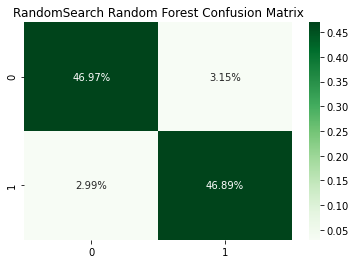

In [ ]:
matrix = metrics.confusion_matrix(y_test,y_hat_rf)
sns.heatmap(matrix/np.sum(matrix), annot=True, 
            fmt='.2%',cmap="Greens")

plt.title('RandomSearch Random Forest Confusion Matrix')
plt.show()

In [ ]:
coef = random_forest_model.best_estimator_.feature_importances_
names = X_scaled_train.columns.values
df = pd.DataFrame({'Column Name':names,'Feature Importances':coef}).sort_values(by='Feature Importances',ascending=False)
top_25_rf_features = df[0:25]
top_25_rf_features

,Column Name,Feature Importances
373,instrumentalness^2,0.138126
6,instrumentalness,0.125757
367,loudness instrumentalness,0.108553
17,pop,0.065306
28,country,0.049000
19,rap,0.046860
362,alb_type_compilation,0.044671
45,metal,0.025173
15,genres_count,0.021027
150,punk,0.017497


#Bagging

In [ ]:
tree_list = [x for x in range(1,1001)]
depths = [x for x in range(1,101)]
samples = [x/100 for x in range(1,101)]

parameter_grid = {
    'n_estimators': tree_list,
    'base_estimator__max_depth': depths,
    'max_samples': samples
}

bagging_model = RandomizedSearchCV(BaggingClassifier(base_estimator=(DecisionTreeClassifier(random_state=17)),random_state=17), parameter_grid, scoring='accuracy', random_state=17,return_train_score=True)

bagging_model.fit(X_scaled_train,y_train)

bagging_yhat = bagging_model.predict(X_scaled_test)
bagging_yhat_train = bagging_model.predict(X_scaled_train)

best_accuracy_bag = metrics.accuracy_score(y_test,bagging_yhat)
best_accuracy_bag_train = metrics.accuracy_score(y_train,bagging_yhat_train)

In [ ]:
print('Test Accuracy:',best_accuracy_bag)
print('Train Accuracy:',best_accuracy_bag_train)
print(bagging_model.best_estimator_)

Test Accuracy: 0.9377462568951931
Train Accuracy: 0.9996059113300493
BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=73,
                                                        random_state=17),
                  max_samples=0.86, n_estimators=360, random_state=17)


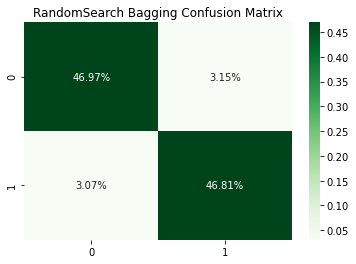

In [ ]:
matrix = metrics.confusion_matrix(y_test,bagging_yhat)
sns.heatmap(matrix/np.sum(matrix), annot=True, 
            fmt='.2%',cmap="Greens")

plt.title('RandomSearch Bagging Confusion Matrix')
plt.show()

In [ ]:
bag_importances = []
for i,x in enumerate(bagging_model.best_estimator_.estimators_):
  bag_importances.append(bagging_model.best_estimator_.estimators_[i].feature_importances_)
bag_importance_df = pd.DataFrame(bag_importances,columns=X_scaled_test.columns)
top_25_bag_features = pd.DataFrame({'Derived Feature Importance':bag_importance_df.mean().sort_values(ascending=False)[0:25]})
top_25_bag_features

,Derived Feature Importance
instrumentalness^2,0.128781
instrumentalness,0.126624
loudness instrumentalness,0.115701
pop,0.064284
country,0.047328
alb_type_compilation,0.045732
rap,0.045508
metal,0.026707
genres_count,0.020934
punk,0.017034


#Boosting

In [ ]:
learning_params = [x/100 for x in range(1,101)]
tree_list = [x for x in range(1,1001)]
depths = [x for x in range(1,4)]

parameter_grid = {
    'n_estimators': tree_list,
    'learning_rate': learning_params,
    'base_estimator__max_depth': depths
}

boosted_model = RandomizedSearchCV(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=17),random_state=17), parameter_grid, scoring='accuracy', random_state=17,return_train_score=True)

boosted_model.fit(X_scaled_train,y_train)

boosted_yhat = boosted_model.predict(X_scaled_test)
boosted_yhat_train = boosted_model.predict(X_scaled_train)

best_accuracy_boost = metrics.accuracy_score(y_test,boosted_yhat)
best_accuracy_boost_train = metrics.accuracy_score(y_train,boosted_yhat_train)

In [ ]:
print('Best Test Accuracy:',best_accuracy_boost)
print('Best Train Accuracy:',best_accuracy_boost_train)
print(boosted_model.best_estimator_)

Best Test Accuracy: 0.9361702127659575
Best Train Accuracy: 0.9996059113300493
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,
                                                         random_state=17),
                   learning_rate=0.26, n_estimators=681, random_state=17)


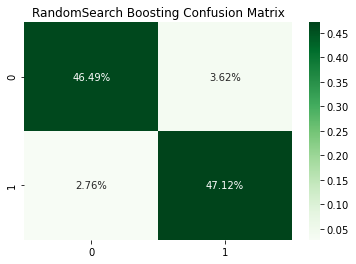

In [ ]:
matrix = metrics.confusion_matrix(y_test,boosted_yhat)
sns.heatmap(matrix/np.sum(matrix), annot=True, 
            fmt='.2%',cmap="Greens")

plt.title('RandomSearch Boosting Confusion Matrix')
plt.show()

In [ ]:
boost_importances = []
for i,x in enumerate(boosted_model.best_estimator_.estimators_):
  boost_importances.append(boosted_model.best_estimator_.estimators_[i].feature_importances_)
boost_importance_df = pd.DataFrame(boost_importances,columns=X_scaled_test.columns)
top_25_boosted_features = pd.DataFrame({'Derived Feature Importance':boost_importance_df.mean().sort_values(ascending=False)[0:25]})
top_25_boosted_features

,Derived Feature Importance
valence,0.055962
duration_seconds,0.045929
danceability,0.043621
tempo,0.042913
genres_count,0.040153
liveness,0.038289
album_tracks,0.038122
speechiness,0.036062
loudness energy,0.032938
energy acousticness,0.030545


#Stacking Classifier

In [ ]:
from sklearn.ensemble import StackingClassifier

estimators =[('bagging', bagging_model.best_estimator_),
('rf', random_forest_model.best_estimator_),
('boost', boosted_model.best_estimator_),
('knn', knn_model.best_estimator_),
('logistic', logistic_model.best_estimator_),
('ridge', ridge_model.best_estimator_),
('dt',dt.best_estimator_)]

stacked_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(),cv=5)
stacked_model.fit(X_scaled_train, y_train)

yhat_stacked = stacked_model.predict(X_scaled_test)
yhat_stacked_train = stacked_model.predict(X_scaled_train)

stacked_acc = metrics.accuracy_score(y_test, yhat_stacked)
stacked_acc_train = metrics.accuracy_score(y_train, yhat_stacked_train)

In [ ]:
print('Test Accuracy:',stacked_acc)
print('Train Accuracy:',stacked_acc_train)

Test Accuracy: 0.9401103230890465
Train Accuracy: 0.9982266009852216


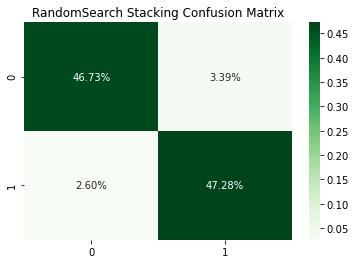

In [ ]:
matrix = metrics.confusion_matrix(y_test,yhat_stacked)
sns.heatmap(matrix/np.sum(matrix), annot=True, 
            fmt='.2%',cmap="Greens")

plt.title('RandomSearch Stacking Confusion Matrix')
plt.show()

#ROC Curve Comparison

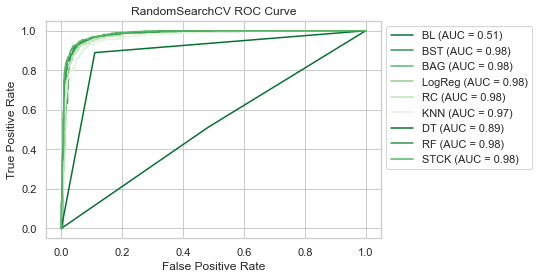

In [ ]:
modelset = [best_baseline_model,boosted_model,bagging_model,logistic_model,ridge_model,knn_model,dt,random_forest_model,stacked_model]

model_names = ['BL','BST','BAG','LogReg','RC','KNN','DT','RF','STCK']

#Define the colors for the chart 

sns.set(palette="Greens_r",style='whitegrid')

#Set up the model to stack plots for each classifier

axis = plt.gca()

#iterate through all models

for i,met in enumerate(modelset):
    #Plot the ROC curve for a given model

  metrics.plot_roc_curve(met,X_scaled_test,y_test,ax=axis,name=model_names[i])
 
  #Add legend and title to chart to finish it off

  plt.legend(bbox_to_anchor=(1, 1))
  plt.title('RandomSearchCV ROC Curve')
plt.show()

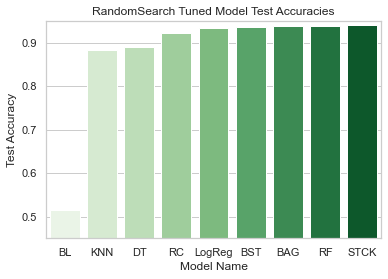

In [ ]:
accuracies= [best_baseline_accuracy,logistic_accuracy,ridge_accuracy,tree_acc,knn_acc,rf_acc,best_accuracy_boost,best_accuracy_bag,stacked_acc]
train_accuracies = [best_baseline_accuracy_train,logistic_accuracy_train,ridge_accuracy_train,tree_train_acc,knn_train_acc,rf_train_acc,best_accuracy_boost_train,best_accuracy_bag_train,stacked_acc_train]

model_names = ['BL','LogReg','RC','DT','KNN','RF','BST','BAG','STCK']

models = pd.DataFrame({'Model Name':model_names,'Test Accuracy':accuracies,'Train Accuracy':train_accuracies}).sort_values(by='Test Accuracy')

sns.set(palette="Greens_r",style='whitegrid')
sns.barplot(y=models['Test Accuracy'],x=models['Model Name'],palette='Greens').set_ylim(.45,.95)
plt.title('RandomSearch Tuned Model Test Accuracies')
plt.show()

In [ ]:
#Create a new column on the dataframe to show the differences between train/test and understand how much all of our models overfit
models['Difference'] = models['Test Accuracy'] - models['Train Accuracy']

#Sort by test accuracy and display
models = models.sort_values(by='Test Accuracy', ascending=False)
models 

,Model Name,Test Accuracy,Train Accuracy,Difference
8,STCK,0.940110,0.998227,-0.058116
5,RF,0.938534,0.999606,-0.061072
7,BAG,0.937746,0.999606,-0.061860
6,BST,0.936170,0.999606,-0.063436
1,LogReg,0.933806,0.947192,-0.013386
2,RC,0.922774,0.940099,-0.017325
3,DT,0.889677,0.999606,-0.109929
4,KNN,0.883373,0.999606,-0.116233
0,BL,0.514578,0.508177,0.006401
